# Sin Activation Function Instead of Tanh

In [8]:
%run "../HyperParameterOpt/GenerateExperiments/res_experiment.py"
import copy
from matplotlib import pyplot as plt
import scipy as sp
from scipy import signal
from rescomp import BatchResComp
DIFF_EQ_PARAMS = {
                  "x0": [-20, 10, -.5],
                  "begin": 0,
                  "end": 85,
                  "timesteps": 85000,
                  "train_per": .889,
                  "solver": lorenz_equ,
                  "clip": 40
                 }

RES_PARAMS = {
              "uniform_weights": True,
              "solver": "ridge",
              "ridge_alpha": 1e-6,
              "signal_dim": 3,
              "network": "random graph",

              "res_sz": 2500,
              "activ_f": np.sin,
              "connect_p": .1,
              "spect_rad": 5.0,
              "gamma": 10,
              "sigma": .14,
              "sparse_res": True,
             }

TOL = 5
plt.rcParams["figure.figsize"] = [15, 5]

In [9]:
def adj_matrix(topology, topo_params, n, remove_p=0):
    adj = generate_adj(topology, topo_params, n)
    adj = remove_edges(adj, floor(remove_p*np.sum(adj != 0)))
    return adj

def mean_driven_state(A):
    DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
    train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
    rc = ResComp(A, **RES_PARAMS)
    states = rc.drive(train_t, u)
    mean_node_state = np.mean(states, axis=1)
    return mean_node_state

In [10]:
def kuramoto_order(peaktimes, t):
    """ Compute the kuramoto order parameter of a system of oscilators.
        Parameters:
        ----------
        peaktimes (list): A list of length N > 1 where each entry is an array of 
                          oscilator peak times (use scipy.signal.find_peaks_cwt)
        t (ndarry): Time values where the order parameter should be computed
        Returns
        -------
        R (ndarray): kuramoto order parameter for each of the timesteps in t
    """
    R = np.zeros(len(t), np.complex)
    timemask = np.argsort(t)
    for peaks in peaktimes:
        prevpeak = peaks[1]
        prevprevpeak = peaks[0]
        j = 2
        for i, ti in enumerate(t[timemask]):
            if j >= len(peaks) - 1: break
            # Find first t value that occurs after the first peak
            if ti < prevpeak:
                pass
            # Find the first peak that is greater than the time value
            if ti >= peaks[j]:
                prevprevpeak = prevpeak
                prevpeak = peaks[j]
                j += 1
            # Compute kuramoto order
            if (ti >= prevpeak) and (ti < peaks[j]):
                phi = 2 * np.pi *(ti - prevpeak) / (prevpeak - prevprevpeak)
                R[i] += np.exp(1j*phi)
    R = np.abs(R) / len(peaktimes)
    return R

def state_peaks(t, states):
    peaks = []
    for i in range(states.shape[1]):
        peakidx = sp.signal.find_peaks(states[:,i].T)[0]
        peaktimes = t[peakidx]
        peaks.append(peaktimes)
    return peaks

In [11]:
def rc_kuramoto_ord(topo, topo_p=4, n=2500, remove_p=0.0):
    DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
    train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
    A = adj_matrix(topo, topo_p, n, remove_p=remove_p)
    rc = ResComp(A, **RES_PARAMS)
    states = rc.drive(train_t, u)
    t = np.arange(len(states)) / 1000.0
    mask = np.abs(np.mean(states, axis=0)) > .97
    print("Number of steady states: ", np.sum(mask))
    peaks = state_peaks(t, states[:, ~mask])
    ko = kuramoto_order(peaks, t)
    print("Mean Kuramoto Order: ", np.mean(ko))
    return ko


In [32]:
RES_PARAMS = {
              "uniform_weights": True,
              "solver": "ridge",
              "ridge_alpha": 1e-6,
              "signal_dim": 3,
              "network": "random graph",
              "res_sz": 2500,
              "activ_f": lambda x: np.sin(x/np.pi),
              "connect_p": .1,
              "spect_rad": 5.0,
              "gamma": 10,
              "sigma": .14,
              "sparse_res": True,
             }

In [33]:
n = 1000
DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
A = adj_matrix("random_digraph", 2, n, remove_p=0.0)
rc = ResComp(A, **RES_PARAMS)
states = rc.drive(train_t, u)

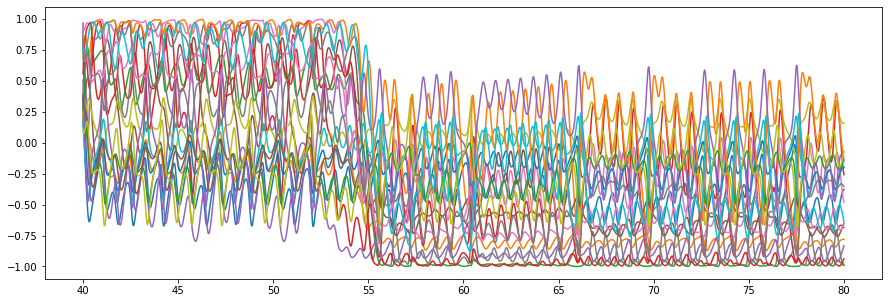

In [40]:
stateidx = np.random.randint(0, high=n, size=20)
plt.plot(train_t, states[:, stateidx])
plt.show()

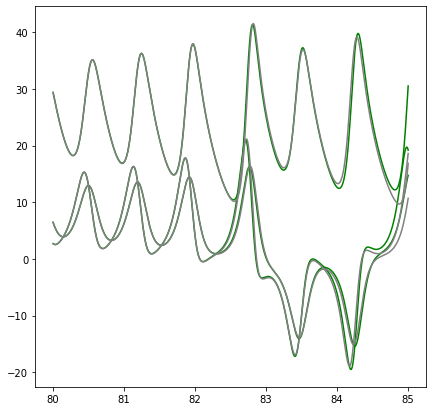

In [101]:
n = 2000
DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
A = adj_matrix("random_digraph", 2, n, remove_p=0.0)
rc = ResComp(A, **RES_PARAMS)
err = rc.fit(train_t, u)
pred = rc.predict(test_t)
plt.plot(test_t, pred.T, c='g')
plt.plot(test_t, u(test_t).T, c="grey")
plt.show()

Accuracy Duration:  1267


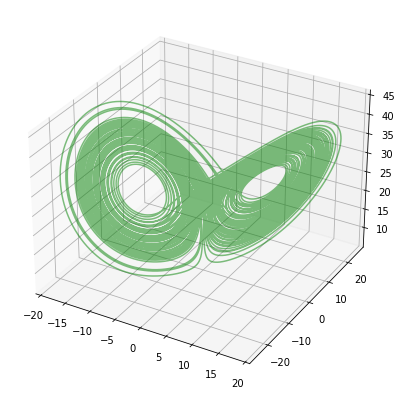

In [379]:
plt.rcParams["figure.figsize"] = [7,7]
n = 100
DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
RES_PARAMS["activ_f"] = lambda x: 1/(1+np.exp(-1*x))
#RES_PARAMS["activ_f"] = np.sin
#RES_PARAMS["activ_f"] = lambda x: 1/(1+x**2)
#RES_PARAMS["activ_f"] = np.arctan
RES_PARAMS["activ_f"] = np.tanh

train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
A = adj_matrix("ident", 0.1, n, remove_p=0.8)
rc = ResComp(A, **RES_PARAMS)
err = rc.fit(train_t, u)
t = np.arange(80000) / 1000
pred = rc.predict(t)
print("Accuracy Duration: ", how_long_accurate(u(test_t), pred))

ax = plt.axes(projection='3d')

x,y,z = pred[0,:], pred[1,:], pred[2,:]
ax.plot3D(x, y, z, 'g',alpha=.5, label="Predicted Orbit")

ax.set_title = "3D Orbit"
plt.show()


Number of steady states:  30
Mean Kuramoto Order:  0.42788448372111637


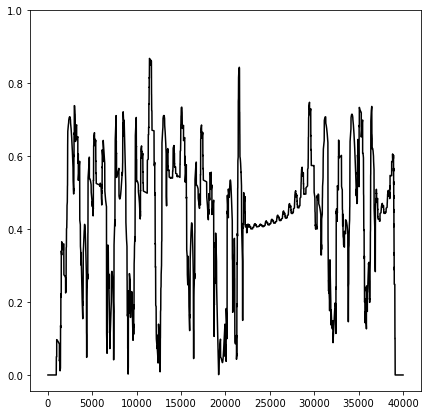

In [110]:
ko = rc_kuramoto_ord("random_digraph", topo_p=2, n=50, remove_p=0.0)
plt.plot(ko, c='k')
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Experiment Idea
(It looks like sigmoid has less variance in its solutions than tanh)

Take reasonable parameter ranges for tanh.

**Dependent:** Accuracy duration, Long Term Infinity norm

**Predictors:** remove percent, steady state percent, kuramoto, sigmoid

**Hypothesis:** sigmoid will reduce accruacy duration variance and decrease Long term infinity norm by a lot.

Accuracy Duration:  1841


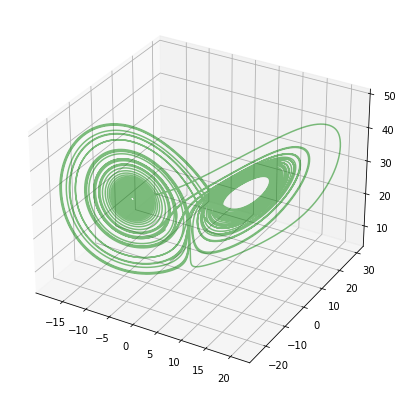

In [435]:
plt.rcParams["figure.figsize"] = [7,7]
n = 100
DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
RES_PARAMS["activ_f"] = lambda x: 1/(1+np.exp(-1*x))
#RES_PARAMS["activ_f"] = np.sin
#RES_PARAMS["activ_f"] = lambda x: 1/(1+x**2)
#RES_PARAMS["activ_f"] = np.arctan
RES_PARAMS["activ_f"] = np.tanh

train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
A = adj_matrix("geom", 2, n, remove_p=0.8)
rc = BatchResComp(A, **RES_PARAMS)
err = rc.fit_batch(train_t, u, 0.5, overlap=0.5)
t = np.arange(80000) / 1000

DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
pred = rc.predict(t, u_0=u(train_t[0]))
print("Accuracy Duration: ", how_long_accurate(u(train_t), pred))

ax = plt.axes(projection='3d')

x,y,z = pred[0,:], pred[1,:], pred[2,:]
ax.plot3D(x, y, z, 'g',alpha=.5, label="Predicted Orbit")

ax.set_title = "3D Orbit"
plt.show()


## Experiment Idea

Cutting connections reduces propensity of the system to diverge

**Dependent Variable** Linf norm

**Predictors** Network size, edge removal, mean degree

## Batch Reservoir Computer Paper

Describe how it works test on three dynamical systems. It should blow them out of the water if I use a random initial condition.

I could stay small: 100 nodes, one choice for each hyper parameter, 3 dynamical systems. Focus on the impact of random initial conditions.

Use the fourier transform to measure goodness of fit.

## Hypothesis

Internal network does not matter unless spectral radius is large enough. Too many edges restricts the variability of the internal states. You need to have a large spectral radius and a few edges to see an impact of topology on performance.

In [499]:
uf = np.abs(sp.fft.fft(u(t)))/len(t)
pf = np.abs(sp.fft.fft(pred))/len(t)


In [500]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ufavg = moving_average(uf[2], n=100)
pfavg = moving_average(pf[2], n=100)

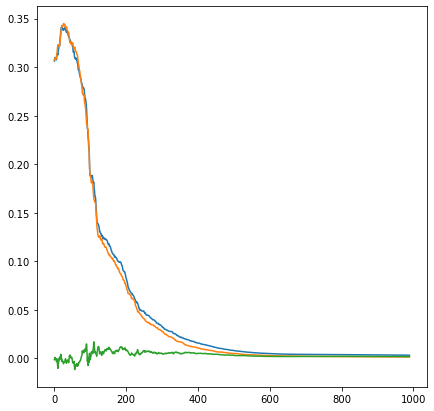

In [501]:
plt.plot(ufavg[10:1000])
plt.plot(pfavg[10:1000])
plt.plot(ufavg[10:1000] - pfavg[10:1000])

In [459]:
plt.plot(uf[2,1:500].T)
plt.plot(pf[2,1:500].T)

IndexError: index 2 is out of bounds for axis 0 with size 0

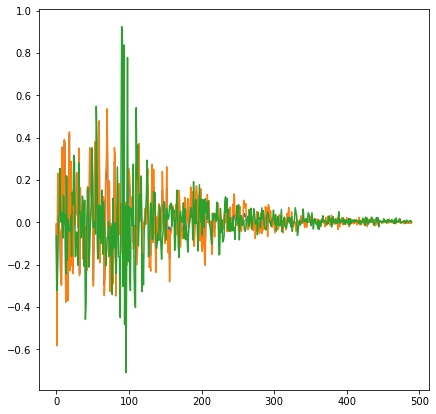

In [445]:
plt.plot(uf[:,10:500].T - pf[:,10:500].T)
